Quick experiment to see which is better at detecting truthful answers

- model outputs
- hs
- supressed activations (Hypothesis this is better)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from loguru import logger
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
from einops import rearrange, repeat
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.data import DataCollatorForLanguageModeling

import torch
from torch import Tensor
from torch.nn.functional import (
    binary_cross_entropy_with_logits as bce_with_logits,
)
from torch.nn.functional import (
    cross_entropy,
)

from jaxtyping import Float
from torch import Tensor

from activation_store.collect import activation_store, default_postprocess_result

## Load model

In [4]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

# Qwen/Qwen3-1.7B-FP8
# Qwen/Qwen3-0.6B-FP8
# model_name = "Qwen/Qwen3-0.6B"

# model_name = "unsloth/Llama-3.2-1B-Instruct"

# model_name = "Qwen/Qwen2.5-3B-Instruct"
# model_name = "Qwen/Qwen2.5-3B-Instruct-AWQ"

# model_name = "AMead10/Llama-3.2-3B-Instruct-AWQ"

# model_name = "unsloth/Phi-4-mini-instruct" # 4b
# model_name = "stelterlab/phi-4-AWQ"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16 if ('awq' not in model_name.lower()) else torch.float16,
    device_map="auto",
    attn_implementation="eager",  # flex_attention  flash_attention_2 sdpa eager
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.paddding_side = "left"
tokenizer.truncation_side = "left"

Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


## Load data and tokenize

In [5]:
# N = 316
max_length = 316
split = "train"
ds1 = load_dataset("Yik/truthfulQA-bool", split=split, keep_in_memory=False)

sys_msg = """You will be given a statement, predict if it is true according to wikipedia, and return only 0 for false and 1 for true.
"""


def proc(row):
    messages = [
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": row["question"]},
        {"role": "assistant", "content": "The answer is "},
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        return_dict=True,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        # add_generation_prompt=True,
        continue_final_message=True,
    )


ds2 = ds1.map(proc).with_format("torch")
new_cols = list(set(ds2.column_names) - set(ds1.column_names)) + ["label"]
ds2 = ds2.select_columns(new_cols)
ds2

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 316
})

## Data loader

In [6]:
collate_fn = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
ds = DataLoader(ds2, batch_size=6, collate_fn=collate_fn)
print(ds)


## Collect activations

In [7]:
# choose layers to cache
layer_groups = {
    'mlp.down_proj': [k for k,v in model.named_modules() if k.endswith('mlp.down_proj')][10:25],
    'self_attn': [k for k,v in model.named_modules() if k.endswith('.self_attn')][10:25],
    'mlp.up_proj': [k for k,v in model.named_modules() if k.endswith('mlp.up_proj')][10:25],
}
# layer_groups = []

In [8]:
f = activation_store(ds, model, layers=layer_groups)
f

2025-05-02 06:14:14.498 | DEBUG    | activation_store.collect:output_dataset_hash:136 - hashing {'generate_batches': 'Function: activation_store.collect.generate_batches', 'loader': 'DataLoader.dataset_c5d9cd414a71f9c3_53_6', 'model': 'PreTrainedModel_Qwen/Qwen2.5-0.5B-Instruct', 'layers': {'mlp.down_proj': ['model.layers.10.mlp.down_proj', 'model.layers.11.mlp.down_proj', 'model.layers.12.mlp.down_proj', 'model.layers.13.mlp.down_proj', 'model.layers.14.mlp.down_proj', 'model.layers.15.mlp.down_proj', 'model.layers.16.mlp.down_proj', 'model.layers.17.mlp.down_proj', 'model.layers.18.mlp.down_proj', 'model.layers.19.mlp.down_proj', 'model.layers.20.mlp.down_proj', 'model.layers.21.mlp.down_proj', 'model.layers.22.mlp.down_proj', 'model.layers.23.mlp.down_proj'], 'self_attn': ['model.layers.10.self_attn', 'model.layers.11.self_attn', 'model.layers.12.self_attn', 'model.layers.13.self_attn', 'model.layers.14.self_attn', 'model.layers.15.self_attn', 'model.layers.16.self_attn', 'model.lay

collecting activations:   0%|          | 0/53 [00:00<?, ?it/s]

PosixPath('/tmp/activation_storepbwer_ay/ds_act__999e5c66eb286524.parquet')

In [9]:
ds_a = Dataset.from_parquet(str(f), split=split).with_format("torch")
ds_a

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['acts-mlp.down_proj', 'acts-self_attn', 'acts-mlp.up_proj', 'loss', 'logits', 'hidden_states', 'label'],
    num_rows: 316
})

In [10]:
act_groups = [c for c in ds_a.column_names if c.startswith('acts-')]
act_groups

['acts-mlp.down_proj', 'acts-self_attn', 'acts-mlp.up_proj']

In [11]:
{k:v.shape for k,v in ds_a[0].items()}

{'acts-mlp.down_proj': torch.Size([14, 1, 896]),
 'acts-self_attn': torch.Size([14, 1, 896]),
 'acts-mlp.up_proj': torch.Size([14, 1, 4864]),
 'loss': torch.Size([]),
 'logits': torch.Size([1, 151936]),
 'hidden_states': torch.Size([25, 1, 896]),
 'label': torch.Size([])}

In [12]:
# sanity test generate
b = next(iter(ds))
b = {k: v.to(model.device) for k, v in b.items()}
o = model.generate(
    inputs=b["input_ids"],
    attention_mask=b["attention_mask"],
    max_new_tokens=3,
)
gent = tokenizer.batch_decode(o, skip_special_tokens=False)
for g in gent:
    print(g)
    print("---")

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


<|im_start|>system
You will be given a statement, predict if it is true according to wikipedia, and return only 0 for false and 1 for true.
<|im_end|>
<|im_start|>user
Drinking Red Bull gives you sugar and stimulants.<|im_end|>
<|im_start|>assistant
The answer is <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

## Get supressed activations

In [13]:
@torch.no_grad()
def get_supressed_activations(
    hs: Float[Tensor, "l b t h"], w_out, w_inv
) -> Float[Tensor, "l b t h"]:
    """
    Novel experiment: Here we define a transform to isolate supressed activations, where we hypothesis that style/concepts/scratchpads and other internal only representations must be stored.

    See the following references for more information:

    - https://arxiv.org/pdf/2401.12181
        - > Suppression neurons that are similar, except decrease the probability of a group of related tokens
        - > We find a striking pattern which is remarkably consistent across the different seeds: after about the halfway point in the model, prediction neurons become increasingly prevalent until the very end of the network where there is a sudden shift towards a much larger number of suppression neurons.

    - https://arxiv.org/html/2406.19384
        - > Previous work suggests that networks contain ensembles of “prediction" neurons, which act as probability promoters [66, 24, 32] and work in tandem with suppression neurons (Section 5.4).


    Output:
    - supression amount: This is a tensor of the same shape as the input hs, where the values are the amount of suppression that occured at that layer, and the sign indicates if it was supressed or promoted. How do we calulate this? We project the hs using the output_projection, look at the diff from the last layer, and then project it back using the inverse of the output projection. This gives us the amount of suppression that occured at that layer.
    """
    hs_flat = rearrange(hs[:, :, -1:], "l b t h -> (l b t) h")
    hs_out_flat = torch.nn.functional.linear(hs_flat, w_out)
    hs_out = rearrange(
        hs_out_flat, "(l b t) h -> l b t h", l=hs.shape[0], b=hs.shape[1], t=1
    )
    diffs = hs_out[:, :, :].diff(dim=0)
    diffs_flat = rearrange(diffs, "l b t h -> (l b t) h")
    # W_inv = get_cache_inv(w_out)

    diffs_inv_flat = torch.nn.functional.linear(diffs_flat.to(dtype=w_inv.dtype), w_inv)
    diffs_inv = rearrange(
        diffs_inv_flat, "(l b t) h -> l b t h", l=hs.shape[0] - 1, b=hs.shape[1], t=1
    ).to(w_out.dtype)

    # add on missing first layer
    torch.zeros_like(diffs_inv[:1]).to(hs.device)
    diffs_inv = torch.cat(
        [torch.zeros_like(diffs_inv[:1]).to(hs.device), diffs_inv], dim=0
    )
    return diffs_inv

In [14]:
def get_uniq_token_ids(tokens):
    token_ids = tokenizer(
        tokens, return_tensors="pt", add_special_tokens=False, padding=True
    ).input_ids
    token_ids = torch.tensor(list(set([x[0] for x in token_ids]))).long()
    print("before", tokens)
    print("after", tokenizer.batch_decode(token_ids))
    return token_ids


false_tokens = ["0", "0 ", "0\n", "false", "False "]
false_token_ids = get_uniq_token_ids(false_tokens)

true_tokens = ["1", "1 ", "1\n", "true", "True "]
true_token_ids = get_uniq_token_ids(true_tokens)

before ['0', '0 ', '0\n', 'false', 'False ']
after ['False', '0', 'false', '0', '0']
before ['1', '1 ', '1\n', 'true', 'True ']
after ['1', 'true', '1', 'True', '1']


In [15]:
# now we map to 1) calc supressed activations 2) llm answer (prob of 0 vs prob of 1)

Wo = model.get_output_embeddings().weight.detach().clone().cpu()
Wo_inv = torch.pinverse(Wo.clone().float())


def proc(o):
    # TODO batch it
    """Process model outputs"""

    # get llm ans
    log_probs = o["logits"][-1].log_softmax(0)
    false_log_prob = log_probs.index_select(0, false_token_ids).sum()
    true_log_prob = log_probs.index_select(0, true_token_ids).sum()
    o["llm_ans"] = torch.stack([false_log_prob, true_log_prob])
    o["llm_log_prob_true"] = true_log_prob - false_log_prob

    # get supressed activations
    hs = o["hidden_states"][None]
    hs = rearrange(hs, "b l t h -> l b t h")
    diffs_inv = get_supressed_activations(hs, Wo.to(hs.dtype), Wo_inv.to(hs.dtype))

    # we will only take the last half of layers, and the last token
    layer_half = hs.shape[0] // 2
    
    hs = rearrange(hs, "l b t h -> b l t h").squeeze(0)[layer_half:-2]
    diffs_inv = rearrange(diffs_inv, "l b t h -> b l t h").squeeze(0)[layer_half:-2]

    o["hidden_states"] = hs.half()
    o["diffs_inv"] = diffs_inv.half()
    return o


ds_a2 = ds_a.map(proc, writer_batch_size=1, num_proc=None)
ds_a2

Map:   0%|          | 0/316 [00:00<?, ? examples/s]

Dataset({
    features: ['acts-mlp.down_proj', 'acts-self_attn', 'acts-mlp.up_proj', 'loss', 'logits', 'hidden_states', 'label', 'llm_ans', 'llm_log_prob_true', 'diffs_inv'],
    num_rows: 316
})

In [16]:
{k: v.shape for k,v in ds_a2[0].items() if isinstance(v, torch.Tensor)}


{'acts-mlp.down_proj': torch.Size([14, 1, 896]),
 'acts-self_attn': torch.Size([14, 1, 896]),
 'acts-mlp.up_proj': torch.Size([14, 1, 4864]),
 'loss': torch.Size([]),
 'logits': torch.Size([1, 151936]),
 'hidden_states': torch.Size([11, 1, 896]),
 'label': torch.Size([]),
 'llm_ans': torch.Size([2]),
 'llm_log_prob_true': torch.Size([]),
 'diffs_inv': torch.Size([11, 1, 896])}

## Predict

In [17]:
# # https://github.com/EleutherAI/ccs/blob/8a4bf687712cc03ef72973c8235944566d59053b/ccs/training/supervised.py#L9
# # TODO just replace with skotch or ridge regression

# class Classifier(torch.nn.Module):
#     """Linear classifier trained with supervised learning."""

#     def __init__(
#         self,
#         input_dim: int,
#         num_classes: int = 2,
#         device: str | torch.device | None = None,
#         dtype: torch.dtype | None = None,
#     ):
#         super().__init__()

#         self.linear = torch.nn.Linear(
#             input_dim, num_classes if num_classes > 2 else 1, device=device, dtype=dtype
#         )
#         self.linear.bias.data.zero_()
#         # self.linear.weight.data.zero_()

#     def forward(self, x: Tensor) -> Tensor:
#         return self.linear(x).squeeze(-1)

#     @torch.enable_grad()
#     def fit(
#         self,
#         x: Tensor,
#         y: Tensor,
#         *,
#         l2_penalty: float = 0.001,
#         max_iter: int = 10_000,
#     ) -> float:
#         """Fits the model to the input data using L-BFGS with L2 regularization.

#         Args:
#             x: Input tensor of shape (N, D), where N is the number of samples and D is
#                 the input dimension.
#             y: Target tensor of shape (N,) for binary classification or (N, C) for
#                 multiclass classification, where C is the number of classes.
#             l2_penalty: L2 regularization strength.
#             max_iter: Maximum number of iterations for the L-BFGS optimizer.

#         Returns:
#             Final value of the loss function after optimization.
#         """
#         optimizer = torch.optim.LBFGS(
#             self.parameters(),
#             line_search_fn="strong_wolfe",
#             max_iter=max_iter,
#         )

#         num_classes = self.linear.out_features
#         loss_fn = bce_with_logits if num_classes == 1 else cross_entropy
#         loss = torch.inf
#         y = y.to(
#             torch.get_default_dtype() if num_classes == 1 else torch.long,
#         )

#         def closure():
#             nonlocal loss
#             optimizer.zero_grad()

#             # Calculate the loss function
#             logits = self(x).squeeze(-1)
#             loss = loss_fn(logits, y)
#             if l2_penalty:
#                 reg_loss = loss + l2_penalty * self.linear.weight.square().sum()
#             else:
#                 reg_loss = loss

#             reg_loss.backward()
#             return float(reg_loss)

#         optimizer.step(closure)
#         return float(loss)


In [18]:
# # first try llm


# def roc_auc(y_true: Tensor, y_pred: Tensor) -> Tensor:
#     """Area under the receiver operating characteristic curve (ROC AUC).

#     Unlike scikit-learn's implementation, this function supports batched inputs of
#     shape `(N, n)` where `N` is the number of datasets and `n` is the number of samples
#     within each dataset. This is primarily useful for efficiently computing bootstrap
#     confidence intervals.

#     Args:
#         y_true: Ground truth tensor of shape `(N,)` or `(N, n)`.
#         y_pred: Predicted class tensor of shape `(N,)` or `(N, n)`.

#     Returns:
#         Tensor: If the inputs are 1D, a scalar containing the ROC AUC. If they're 2D,
#             a tensor of shape (N,) containing the ROC AUC for each dataset.
#     """
#     if y_true.shape != y_pred.shape:
#         raise ValueError(
#             f"y_true and y_pred should have the same shape; "
#             f"got {y_true.shape} and {y_pred.shape}"
#         )
#     if y_true.dim() not in (1, 2):
#         raise ValueError("y_true and y_pred should be 1D or 2D tensors")

#     # Sort y_pred in descending order and get indices
#     indices = y_pred.argsort(descending=True, dim=-1)

#     # Reorder y_true based on sorted y_pred indices
#     y_true_sorted = y_true.gather(-1, indices)

#     # Calculate number of positive and negative samples
#     num_positives = y_true.sum(dim=-1)
#     num_negatives = y_true.shape[-1] - num_positives

#     # Calculate cumulative sum of true positive counts (TPs)
#     tps = torch.cumsum(y_true_sorted, dim=-1)

#     # Calculate cumulative sum of false positive counts (FPs)
#     fps = torch.cumsum(1 - y_true_sorted, dim=-1)

#     # Calculate true positive rate (TPR) and false positive rate (FPR)
#     tpr = tps / num_positives.view(-1, 1)
#     fpr = fps / num_negatives.view(-1, 1)

#     # Calculate differences between consecutive FPR values (widths of trapezoids)
#     fpr_diffs = torch.cat(
#         [fpr[..., 1:] - fpr[..., :-1], torch.zeros_like(fpr[..., :1])], dim=-1
#     )

#     # Calculate area under the ROC curve for each dataset using trapezoidal rule
#     return torch.sum(tpr * fpr_diffs, dim=-1).squeeze()


In [19]:
TRAIN_TEST_SPLIT = int(max_length * 0.8)
TRAIN_TEST_SPLIT


252

In [20]:
# def train_linear_prob_on_dataset(
#     X,
#     name="",
#     device: str = "cuda",
# ):
#     X = X.view(len(X), -1).to(device)

#     # norm X
#     X = (X - X.mean()) / X.std()
#     y = ds_a2["label"].to(device)
#     X_train, y_train = X[:train_test_split], y[:train_test_split]
#     X_test, y_test = X[train_test_split:], y[train_test_split:]
#     # data.shape
#     lr_model = Classifier(X.shape[-1], device=device)
#     lr_model.fit(X_train, y_train)

#     y_pred = lr_model.forward(X_test)

#     score = roc_auc(y_test, y_pred)
#     logger.info(f"score for probe({name}): {score:.3f} roc auc, n={len(X_test)}. X.shape={X.shape}")
#     return score.cpu().item()

# Or Skorch

In [21]:
import numpy as np

from torch import nn

from skorch import NeuralNetRegressor
from skorch.toy import make_regressor

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [22]:
def train_linear_prob_on_dataset(
    X,
    name="",
    device: str = "cuda",
):
    X = X.view(len(X), -1).to(device)

    # norm X
    X = ((X - X.mean()) / X.std())
    if X.ndim == 1:
        X = X.unsqueeze(1)
    y = ds_a2["label"].to(device).float()
    if y.ndim == 1:
        y = y.unsqueeze(1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    # data.shape


    lr_model = NeuralNetRegressor(
        make_regressor(num_hidden=0, dropout=0, input_units=X.shape[-1]),
        lr=0.01,
        max_epochs=40,
        batch_size=128,
        device='cuda',  # uncomment this to train with CUDA
        optimizer=torch.optim.Adam,
        optimizer__weight_decay=0.001,
        verbose=0,
    )
    # lr_model = Classifier(X.shape[-1], device=device)
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.forward(X_test).detach().cpu().numpy()

    score = roc_auc_score(y_test.detach().cpu().numpy(), y_pred)
    logger.info(f"score for probe({name}): {score:.3f} roc auc, n={len(X_test)}. X.shape={X.shape}")
    return score#.cpu().item()

### score hidden states and activations

In [23]:
def calc_supp_thresh(hs, diffs_inv, eps = 1.0e-2):
    supressed_mask = (diffs_inv < -eps).to(hs.dtype)
    hs_sup = hs * supressed_mask
    return hs_sup, supressed_mask

In [24]:
def softmax(x, dim=-1):
    """Apply softmax along specified dimension"""
    x_exp = torch.exp(x - torch.max(x, dim=dim, keepdim=True)[0])
    return x_exp / torch.sum(x_exp, dim=dim, keepdim=True)

def magnitude_filtered_post_softmax(x, threshold=0.7, dim=-1):
    """Filter out tokens with abnormally high post-softmax values"""
    # Apply softmax to get attention-like weights
    weights = softmax(x.norm(dim=-1))  # Normalize across hidden dimension first, then softmax
    
    # Create mask for tokens below threshold
    mask = weights <= threshold
    
    # Ensure we don't filter everything out
    if mask.sum() == 0:
        # Keep all but the highest attention token
        _, max_idx = weights.max(dim=0)
        mask = torch.ones_like(weights, dtype=torch.bool)
        mask[max_idx] = False
    
    return x[mask]

In [25]:
def percentile_filtered(x, percentile=90):
    """Filter out tokens with attention weights above a percentile threshold"""
    weights = softmax(x.norm(dim=-1))
    threshold = torch.quantile(weights, percentile/100.0)
    mask = weights <= threshold
    if mask.sum() == 0:
        mask = torch.ones_like(weights, dtype=torch.bool)
        mask[weights.argmax()] = False
    return x[mask]

In [26]:
def entropy_guided_filter(x, z_threshold=2.0):
    """Filter tokens with entropy-based threshold using mean/std statistics
    
    Args:
        x: Input tensor of shape [tokens, hidden_dim]
        z_threshold: How many standard deviations from mean to use as threshold
        
    Returns:
        Filtered tensor with high-attention tokens removed
    """
    # Get attention-like weights
    weights = softmax(x.norm(dim=-1))
    
    # Calculate entropy for each token
    entropy_per_token = -weights * torch.log(weights + 1e-10)
    
    # Get statistics across tokens
    mean_entropy = entropy_per_token.mean()
    std_entropy = entropy_per_token.std()
    
    # Create threshold based on z-score
    threshold = mean_entropy + (z_threshold * std_entropy)
    
    # Create mask for tokens below threshold
    mask = entropy_per_token <= threshold
    
    # Ensure we don't filter everything
    if mask.sum() == 0:
        mask = torch.ones_like(weights, dtype=torch.bool)
        mask[entropy_per_token.argmax()] = False
    
    return x[mask]

In [27]:
# Add new reduction functions that filter out potential attention sinks
def filter_special_positions(x, positions_to_exclude=[0, -1]):
    """Filter out specific positions like first (BOS) and last token"""
    mask = torch.ones(x.shape[0], dtype=torch.bool, device=x.device)
    for pos in positions_to_exclude:
        if pos < 0:
            actual_pos = x.shape[0] + pos
        else:
            actual_pos = pos
        if 0 <= actual_pos < x.shape[0]:
            mask[actual_pos] = False
    return x[mask]

def filter_high_magnitude(x, threshold_factor=2.0):
    """Filter out tokens with abnormally high magnitude (potential attention sinks)"""
    magnitudes = torch.norm(x, dim=-1)
    mean_mag = magnitudes.mean()
    std_mag = magnitudes.std()
    threshold = mean_mag + threshold_factor * std_mag
    mask = magnitudes <= threshold
    if mask.sum() > 0:  # Ensure we don't filter everything
        return x[mask]
    else:
        # Fallback: keep all but the highest magnitude
        _, sorted_indices = torch.sort(magnitudes, descending=True)
        mask = torch.ones_like(magnitudes, dtype=torch.bool)
        mask[sorted_indices[0]] = False
        return x[mask]

# Extended reductions dictionary with sink-aware methods
reductions = {
    "mean": lambda x: x.mean(0),
    "max": lambda x: x.max(0)[0],
    "sum": lambda x: x.sum(0),
    "last": lambda x: x[-1],
    "first": lambda x: x[0],
    "none": lambda x: x,
    # New sink-aware reductions
    "filtered_mean": lambda x: filter_special_positions(x).mean(0),
    "filtered_max": lambda x: filter_special_positions(x).max(0)[0] if len(filter_special_positions(x)) > 0 else x.max(0)[0],
    "filtered_sum": lambda x: filter_special_positions(x).sum(0),

    "middle_mean": lambda x: x[1:-1].mean(0) if x.shape[0] > 2 else x.mean(0),
    "middle_max": lambda x: x[1:-1].max(0)[0] if x.shape[0] > 2 else x.max(0)[0],
    "middle_sum": lambda x: x[1:-1].sum(0) if x.shape[0] > 2 else x.sum(0),

    "magnitude_filtered_mean": lambda x: filter_high_magnitude(x).mean(0),
    "magnitude_filtered_max": lambda x: filter_high_magnitude(x).max(0)[0],
    "magnitude_filtered_sum": lambda x: filter_high_magnitude(x).sum(0),
    
    # Combined approaches
    "doubly_filtered_mean": lambda x: filter_high_magnitude(filter_special_positions(x)).mean(0),
    "doubly_filtered_max": lambda x: filter_high_magnitude(filter_special_positions(x)).max(0)[0],
    
    # entropy_guided_filter
    "entropy_filtered_mean": lambda x: entropy_guided_filter(x).mean(0),
    "entropy_filtered_max": lambda x: entropy_guided_filter(x).max(0)[0],
    "entropy_filtered_sum": lambda x: entropy_guided_filter(x).sum(0),

    # percentile_filtered
    "percentile_filtered_mean": lambda x: percentile_filtered(x).mean(0),
    "percentile_filtered_max": lambda x: percentile_filtered(x).max(0)[0],
    "percentile_filtered_sum": lambda x: percentile_filtered(x).sum(0),

    # magnitude_filtered_post_softmax
    "magnitude_filtered_post_softmax_mean": lambda x: magnitude_filtered_post_softmax(x).mean(0),
    "magnitude_filtered_post_softmax_max": lambda x: magnitude_filtered_post_softmax(x).max(0)[0],
    "magnitude_filtered_post_softmax_sum": lambda x: magnitude_filtered_post_softmax(x).sum(0),
}

results = []

ds_cols = ["hidden_states",] + act_groups

# Include all reductions or a subset focused on the sink-aware ones
sink_aware_reductions = ["filtered_mean", "filtered_max", "middle_mean", "middle_max", 
                        "magnitude_filtered_mean", "magnitude_filtered_max",
                        "doubly_filtered_mean", "doubly_filtered_max"]

# You could choose to run all or focus on just sink-aware methods
reduction_keys = list(reductions.keys())  # All methods
# reduction_keys = sink_aware_reductions  # Only sink-aware methods

# first try hidden states
for r1 in reduction_keys:
    for ds_col in ds_cols:
        r1f = reductions[r1]
        try:
            X = torch.stack([r1f(x.float()) for x in ds_a2[ds_col]])
            name = f"{ds_col} {r1}"
            score = train_linear_prob_on_dataset(X, name)
            results.append((name, score))
        except Exception as e:
            logger.error(f"error with {name} {e}")
            # Continue rather than raising to avoid stopping the entire experiment
            continue

2025-05-02 06:16:29.352 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states mean): 0.655 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:16:29.599 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj mean): 0.639 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:16:29.829 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn mean): 0.685 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:16:30.136 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj mean): 0.597 roc auc, n=64. X.shape=torch.Size([316, 4864])
2025-05-02 06:16:30.358 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states max): 0.637 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:16:30.590 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj max): 0.636 roc auc, n=64. X.sh

In [28]:
# results = []
# filter_high_magnitude(x).max(0)[0]

for filt in [-8, -4, -2, -1, 0, 1, 2, 4, 8]:
    for ds_col in ds_cols:
        try:
            print(name, X[0].shape)
            X = [filter_high_magnitude(x.float(), filt) for x in ds_a2[ds_col]]
            name = f"{ds_col} magnitude_filtered({filt})"
            if X[0].ndim > 1:
                X = [x.max(0)[0] for x in X]
                name += " max"
            X = torch.stack(X)
            score = train_linear_prob_on_dataset(X, name)
            results.append((name, score))
        except Exception as e:
            logger.error(f"error with {name} {e}")
            # Continue rather than raising to avoid stopping the entire experiment
            raise
            continue

results = sorted(results, key=lambda x: x[1], reverse=True)
for name, score in results:
    logger.info(f"{name}: {score:.3f} roc auc")

acts-mlp.up_proj magnitude_filtered_post_softmax_sum torch.Size([4864])


2025-05-02 06:16:57.032 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(-8) max): 0.631 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(-8) max torch.Size([896])


2025-05-02 06:16:57.299 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(-8) max): 0.662 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(-8) max torch.Size([896])


2025-05-02 06:16:57.563 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(-8) max): 0.686 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(-8) max torch.Size([896])


2025-05-02 06:16:57.904 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(-8) max): 0.529 roc auc, n=64. X.shape=torch.Size([316, 4864])


acts-mlp.up_proj magnitude_filtered(-8) max torch.Size([4864])


2025-05-02 06:16:58.156 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(-4) max): 0.644 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(-4) max torch.Size([896])


2025-05-02 06:16:58.423 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(-4) max): 0.665 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(-4) max torch.Size([896])


2025-05-02 06:16:58.690 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(-4) max): 0.703 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(-4) max torch.Size([896])


2025-05-02 06:16:59.047 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(-4) max): 0.611 roc auc, n=64. X.shape=torch.Size([316, 4864])


acts-mlp.up_proj magnitude_filtered(-4) max torch.Size([4864])


2025-05-02 06:16:59.294 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(-2) max): 0.675 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(-2) max torch.Size([896])


2025-05-02 06:16:59.555 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(-2) max): 0.664 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(-2) max torch.Size([896])


2025-05-02 06:16:59.818 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(-2) max): 0.644 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(-2) max torch.Size([896])


2025-05-02 06:17:00.162 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(-2) max): 0.624 roc auc, n=64. X.shape=torch.Size([316, 4864])


acts-mlp.up_proj magnitude_filtered(-2) max torch.Size([4864])


2025-05-02 06:17:00.419 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(-1) max): 0.647 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(-1) max torch.Size([896])


2025-05-02 06:17:00.691 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(-1) max): 0.639 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(-1) max torch.Size([896])


2025-05-02 06:17:00.938 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(-1) max): 0.540 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(-1) max torch.Size([896])


2025-05-02 06:17:01.281 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(-1) max): 0.605 roc auc, n=64. X.shape=torch.Size([316, 4864])


acts-mlp.up_proj magnitude_filtered(-1) max torch.Size([4864])


2025-05-02 06:17:01.523 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(0) max): 0.560 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(0) max torch.Size([896])


2025-05-02 06:17:01.775 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(0) max): 0.583 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(0) max torch.Size([896])


2025-05-02 06:17:02.026 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(0) max): 0.675 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(0) max torch.Size([896])


2025-05-02 06:17:02.362 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(0) max): 0.682 roc auc, n=64. X.shape=torch.Size([316, 4864])


acts-mlp.up_proj magnitude_filtered(0) max torch.Size([4864])


2025-05-02 06:17:02.593 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(1) max): 0.598 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(1) max torch.Size([896])


2025-05-02 06:17:02.839 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(1) max): 0.642 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(1) max torch.Size([896])


2025-05-02 06:17:03.093 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(1) max): 0.597 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(1) max torch.Size([896])


2025-05-02 06:17:03.406 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(1) max): 0.586 roc auc, n=64. X.shape=torch.Size([316, 4864])


acts-mlp.up_proj magnitude_filtered(1) max torch.Size([4864])


2025-05-02 06:17:03.644 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(2) max): 0.662 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(2) max torch.Size([896])


2025-05-02 06:17:03.907 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(2) max): 0.667 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(2) max torch.Size([896])


2025-05-02 06:17:04.161 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(2) max): 0.692 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(2) max torch.Size([896])


2025-05-02 06:17:04.500 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(2) max): 0.625 roc auc, n=64. X.shape=torch.Size([316, 4864])


acts-mlp.up_proj magnitude_filtered(2) max torch.Size([4864])


2025-05-02 06:17:04.744 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(4) max): 0.643 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(4) max torch.Size([896])


2025-05-02 06:17:05.001 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(4) max): 0.648 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(4) max torch.Size([896])


2025-05-02 06:17:05.254 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(4) max): 0.667 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(4) max torch.Size([896])


2025-05-02 06:17:05.585 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(4) max): 0.605 roc auc, n=64. X.shape=torch.Size([316, 4864])


acts-mlp.up_proj magnitude_filtered(4) max torch.Size([4864])


2025-05-02 06:17:05.832 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(hidden_states magnitude_filtered(8) max): 0.643 roc auc, n=64. X.shape=torch.Size([316, 896])


hidden_states magnitude_filtered(8) max torch.Size([896])


2025-05-02 06:17:06.103 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.down_proj magnitude_filtered(8) max): 0.635 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-mlp.down_proj magnitude_filtered(8) max torch.Size([896])


2025-05-02 06:17:06.355 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-self_attn magnitude_filtered(8) max): 0.672 roc auc, n=64. X.shape=torch.Size([316, 896])


acts-self_attn magnitude_filtered(8) max torch.Size([896])


2025-05-02 06:17:06.686 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(acts-mlp.up_proj magnitude_filtered(8) max): 0.575 roc auc, n=64. X.shape=torch.Size([316, 4864])
2025-05-02 06:17:06.687 | INFO     | __main__:<module>:24 - acts-self_attn middle_max: 0.766 roc auc
2025-05-02 06:17:06.687 | INFO     | __main__:<module>:24 - acts-self_attn magnitude_filtered_max: 0.753 roc auc
2025-05-02 06:17:06.687 | INFO     | __main__:<module>:24 - acts-self_attn first: 0.721 roc auc
2025-05-02 06:17:06.688 | INFO     | __main__:<module>:24 - acts-self_attn filtered_max: 0.704 roc auc
2025-05-02 06:17:06.688 | INFO     | __main__:<module>:24 - acts-self_attn magnitude_filtered(-4) max: 0.703 roc auc
2025-05-02 06:17:06.688 | INFO     | __main__:<module>:24 - acts-self_attn doubly_filtered_max: 0.700 roc auc
2025-05-02 06:17:06.688 | INFO     | __main__:<module>:24 - acts-self_attn filtered_mean: 0.699 roc auc
2025-05-02 06:17:06.689 | INFO     | __main__:<module>:24 - ac

### score supressed activations

In [29]:
def calc_hs_sup(o, eps = 1.0e-2):
    diffs_inv = o["diffs_inv"]
    hs = o["hidden_states"] # [b l h]
    if eps > 0:
        supressed_mask = (diffs_inv > eps).to(hs.dtype)# [b l h]
    else:
        supressed_mask = (diffs_inv < eps).to(hs.dtype)

    o['supressed_hs'] = hs * supressed_mask
    o['supressed_mask'] = supressed_mask
    # print({k:v.shape for k,v in o.items()})
    return o

In [30]:
{k: v.shape for k,v in ds_a2[0].items() if isinstance(v, torch.Tensor)}


{'acts-mlp.down_proj': torch.Size([14, 1, 896]),
 'acts-self_attn': torch.Size([14, 1, 896]),
 'acts-mlp.up_proj': torch.Size([14, 1, 4864]),
 'loss': torch.Size([]),
 'logits': torch.Size([1, 151936]),
 'hidden_states': torch.Size([11, 1, 896]),
 'label': torch.Size([]),
 'llm_ans': torch.Size([2]),
 'llm_log_prob_true': torch.Size([]),
 'diffs_inv': torch.Size([11, 1, 896])}

In [31]:
import gc
import numpy as np

In [32]:
X = ds_a2['logits']
name = "logits"
score = train_linear_prob_on_dataset(X, name)
results.append((name, score))
score

2025-05-02 06:17:07.171 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(logits): 0.687 roc auc, n=64. X.shape=torch.Size([316, 151936])


np.float64(0.6872549019607843)

In [33]:

X = ds_a2['llm_ans']
y = ds_a2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

score = roc_auc_score(y_test, X_test[:, 0]).item()
if score<0.5:
    score = 1-score
results.append(('llm_ans', score))
score

0.5431372549019607

In [34]:
X = torch.sigmoid(ds_a2['llm_log_prob_true']/10)
y = ds_a2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

score = roc_auc_score(y_test, X_test).item()
results.append(('llm_log_prob_true', score))
score

0.4985294117647059

In [35]:

X, y = ds_a2["llm_log_prob_true"] > 0, ds_a2["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
score = roc_auc_score(X_test, y_test)
print(f"LLM score: {score:.2f} roc auc, n={len(X_test)}")

LLM score: nan roc auc, n=64


/media/wassname/SGIronWolf/projects5/2025/eliciting_suppressed_knowledge/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [36]:
# now various eps
for eps in [-10, -5, -1, -0.5, -0.1, -0.01, -0, 0, 0.01, 0.1, 0.5, 1, 10]:
    gc.collect()
    ds_a3 = ds_a2.map(lambda x:calc_hs_sup(x, eps=eps), num_proc=None, batched=True, batch_size=64, desc=f"eps {eps}")
    mask_mean = ds_a3['supressed_mask'].mean()
    print(f"eps {eps} ds_a3['supressed_mask'].mean()={mask_mean}")
    if mask_mean==0:
        logger.info(f"Skipping {eps} as no supressed activations")
        continue
    data_names = ["supressed_hs", "supressed_mask"]
    for ds_col in data_names:
        try:
            X = torch.stack([r1f(x) for x in ds_a3[ds_col]])
            name = f"{ds_col} {r1} {eps}"
            score = train_linear_prob_on_dataset(X, name)
            results.append((name, score))
        except Exception as e:
            print(f"error with {name}")
            print(e)


eps -10:   0%|          | 0/316 [00:00<?, ? examples/s]

2025-05-02 06:17:09.198 | INFO     | __main__:<module>:8 - Skipping -10 as no supressed activations


eps -10 ds_a3['supressed_mask'].mean()=0.0


eps -5:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -5 ds_a3['supressed_mask'].mean()=1.9906912712031044e-05


2025-05-02 06:17:11.285 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum -5): 0.514 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:11.527 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum -5): 0.520 roc auc, n=64. X.shape=torch.Size([316, 896])


eps -1:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -1 ds_a3['supressed_mask'].mean()=0.024627098813652992


2025-05-02 06:17:13.618 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum -1): 0.549 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:13.847 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum -1): 0.620 roc auc, n=64. X.shape=torch.Size([316, 896])


eps -0.5:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -0.5 ds_a3['supressed_mask'].mean()=0.11503498256206512


2025-05-02 06:17:15.888 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum -0.5): 0.553 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:16.134 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum -0.5): 0.589 roc auc, n=64. X.shape=torch.Size([316, 896])


eps -0.1:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -0.1 ds_a3['supressed_mask'].mean()=0.39203453063964844


2025-05-02 06:17:18.177 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum -0.1): 0.650 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:18.425 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum -0.1): 0.604 roc auc, n=64. X.shape=torch.Size([316, 896])


eps -0.01:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -0.01 ds_a3['supressed_mask'].mean()=0.48998841643333435


2025-05-02 06:17:20.475 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum -0.01): 0.579 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:20.727 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum -0.01): 0.509 roc auc, n=64. X.shape=torch.Size([316, 896])


eps 0:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 0 ds_a3['supressed_mask'].mean()=0.5016429424285889


2025-05-02 06:17:22.747 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum 0): 0.709 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:22.978 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum 0): 0.536 roc auc, n=64. X.shape=torch.Size([316, 896])


eps 0 ds_a3['supressed_mask'].mean()=0.5016429424285889


2025-05-02 06:17:23.448 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum 0): 0.629 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:23.696 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum 0): 0.461 roc auc, n=64. X.shape=torch.Size([316, 896])


eps 0.01:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 0.01 ds_a3['supressed_mask'].mean()=0.48681938648223877


2025-05-02 06:17:25.689 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum 0.01): 0.581 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:25.920 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum 0.01): 0.610 roc auc, n=64. X.shape=torch.Size([316, 896])


eps 0.1:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 0.1 ds_a3['supressed_mask'].mean()=0.3900907337665558


2025-05-02 06:17:28.016 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum 0.1): 0.631 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:28.253 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum 0.1): 0.539 roc auc, n=64. X.shape=torch.Size([316, 896])


eps 0.5:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 0.5 ds_a3['supressed_mask'].mean()=0.11850778013467789


2025-05-02 06:17:30.251 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum 0.5): 0.672 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:30.493 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum 0.5): 0.604 roc auc, n=64. X.shape=torch.Size([316, 896])


eps 1:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 1 ds_a3['supressed_mask'].mean()=0.02674461528658867


2025-05-02 06:17:32.512 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum 1): 0.570 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:32.752 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum 1): 0.460 roc auc, n=64. X.shape=torch.Size([316, 896])


eps 10:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 10 ds_a3['supressed_mask'].mean()=0.0001920053909998387


2025-05-02 06:17:34.820 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_hs magnitude_filtered_post_softmax_sum 10): 0.584 roc auc, n=64. X.shape=torch.Size([316, 896])
2025-05-02 06:17:35.062 | INFO     | __main__:train_linear_prob_on_dataset:35 - score for probe(supressed_mask magnitude_filtered_post_softmax_sum 10): 0.504 roc auc, n=64. X.shape=torch.Size([316, 896])


In [37]:
import pandas as pd

# note hs_sup seems to get more important as we lower the thresh
df = pd.DataFrame(results, columns=["name", "auroc"]).sort_values(
    "auroc", ascending=False
)
print(df.to_markdown())

|     | name                                                     |    auroc |
|----:|:---------------------------------------------------------|---------:|
|   0 | acts-self_attn middle_max                                | 0.765686 |
|   1 | acts-self_attn magnitude_filtered_max                    | 0.752941 |
|   2 | acts-self_attn first                                     | 0.720588 |
| 153 | supressed_hs magnitude_filtered_post_softmax_sum 0       | 0.708824 |
|   3 | acts-self_attn filtered_max                              | 0.703922 |
|   4 | acts-self_attn magnitude_filtered(-4) max                | 0.702941 |
|   5 | acts-self_attn doubly_filtered_max                       | 0.7      |
|   7 | acts-self_attn percentile_filtered_sum                   | 0.69902  |
|   6 | acts-self_attn filtered_mean                             | 0.69902  |
|   8 | acts-self_attn max                                       | 0.693137 |
|   9 | acts-self_attn magnitude_filtered(2) max                

In [38]:
df['data'] = df['name'].apply(lambda x: x.split()[0])
df2 = df.groupby('data').max().sort_values("auroc", ascending=False)
df2

,name,auroc
data,,
acts-self_attn,acts-self_attn sum,0.765686
supressed_hs,supressed_hs magnitude_filtered_post_softmax_s...,0.708824
logits,logits,0.687255
hidden_states,hidden_states sum,0.685294
acts-mlp.up_proj,acts-mlp.up_proj sum,0.682353
acts-mlp.down_proj,acts-mlp.down_proj sum,0.672549
supressed_mask,supressed_mask magnitude_filtered_post_softmax...,0.619608
llm_ans,llm_ans,0.543137
llm_log_prob_true,llm_log_prob_true,0.498529


/tmp/ipykernel_2637475/1082231495.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


PosixPath('../figs/truthfulqa_Qwen_Qwen2.5-0.5B-Instruct.png')

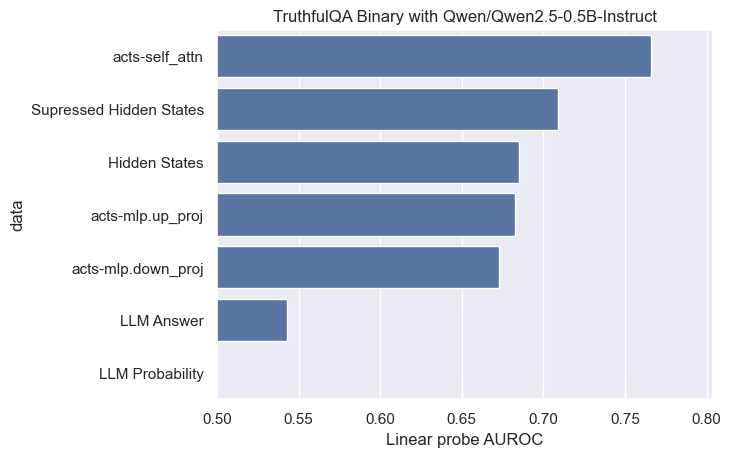

In [39]:
# plot it

from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
sns.set_theme()

c = ['llm_ans', 'llm_log_prob_true', 'hidden_states',  'supressed_hs'] + act_groups
df3 = df2.T[c].rename(columns={
    'llm_ans': 'LLM Answer',
    'llm_log_prob_true': 'LLM Probability',
    'hidden_states': 'Hidden States',
    'acts': 'Activations: up_proj',
    # 'logits': 'Logits',
    'supressed_hs': 'Supressed Hidden States',
}).T.sort_values("auroc", ascending=False)
# df3.plot.barh()
sns.barplot(data=df3, x='auroc', y=df3.index)
plt.legend().remove()
plt.xlabel(f"Linear probe AUROC")
plt.title(f"TruthfulQA Binary with {model_name}")
plt.xlim(0.5, None)
f = Path('../figs/').joinpath(f"truthfulqa_{model_name.replace('/', '_')}.png")
plt.savefig(str(f), bbox_inches='tight')
f